In [24]:
# -*- coding: utf8

from label_shift.skwrapper import LabelShiftDetectorSKLearn

from statsmodels.distributions.empirical_distribution import ECDF

from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn import neural_network
from sklearn import linear_model
from sklearn import svm
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

plt.ion()
np.random.seed(100)

import warnings
warnings.filterwarnings('ignore')


In [25]:
def get_data(test_size=0.2):
    digits = datasets.load_digits()

    images_and_labels = list(zip(digits.images, digits.target))
    n_samples = len(digits.images)
    data = digits.images.reshape((n_samples, -1))

    X = data
    y = digits.target
    return model_selection.train_test_split(X, y, test_size=test_size)

def sample_unbalanced(y_train, ko_classes, ko_prob = 0.9):

    keep = np.ones(len(y_train), dtype='bool')
    for i in range(len(y_train)):
        if y_train[i] in ko_classes and np.random.rand() < ko_prob:
            keep[i] = False
            
    print("Percent retained:", keep.sum() / keep.shape[0])
    
    labels, count = np.unique(y_train[keep], return_counts=True)
    plt.bar(labels, count)
    plt.show()
    
    return keep

def get_class_weights(classifier):
    weights = classifier.wt_est_[:, 0].copy()
    weights = weights / weights.sum()
    class_weights = {}
    for k in range(len(weights)):
        class_weights[k] = weights[k]
    return class_weights

Percent retained: 0.2651356993736952


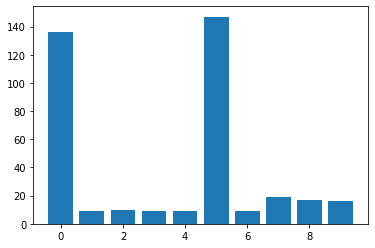

In [26]:
ko_classes = {1, 2, 3, 4, 6, 7, 8, 9}
ko_prob = 0.9

X_train_full, X_test, y_train_full, y_test = get_data(test_size=0.2)
keep = sample_unbalanced(y_train_full, ko_classes, ko_prob)

X_train = X_train_full[keep]
y_train = y_train_full[keep]

### Train the classifier on 1/2 training data, estimate label shift

In [27]:
# base = neural_network.MLPClassifier(hidden_layer_sizes=(128, 128))
# base = svm.SVC(gamma=0.001)
base = linear_model.LogisticRegressionCV()
base_fulldata = linear_model.LogisticRegressionCV()

classifier = LabelShiftDetectorSKLearn(base)
classifier.fit(X_train, y_train)
base.fit(X_train, y_train)
base_fulldata.fit(X_train_full, y_train_full)


class_weights = get_class_weights(classifier)
iwerm_classifier = linear_model.LogisticRegressionCV(class_weight=class_weights)
iwerm_classifier.fit(X_train, y_train)

LogisticRegressionCV(Cs=10,
                     class_weight={0: 0.31554428041367466,
                                   1: 0.030665573852291617,
                                   2: 0.04334688528278828,
                                   3: 0.030171108717352055,
                                   4: 0.030171108717352055,
                                   5: 0.27542936820634034,
                                   6: 0.0274794763938615,
                                   7: 0.10922193833578661,
                                   8: 0.07401893076697075,
                                   9: 0.06395132931358212},
                     cv='warn', dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [28]:
y_pred0 = base.predict(X_test)
y_pred1 = base_fulldata.predict(X_test)
y_pred2 = classifier.predict(X_test)
y_pred3 = iwerm_classifier.predict(X_test)

all_f1 = []
avg_f1 = []
for y_pred in [y_pred0, y_pred1, y_pred2, y_pred3]:
    all_f1.append(metrics.f1_score(y_test, y_pred, labels=list(range(10)), average=None))
    avg_f1.append(metrics.f1_score(y_test, y_pred, average='macro'))

In [29]:
avg_f1

[0.8844057383594089,
 0.9665717860260112,
 0.8844057383594089,
 0.8751280027605803]

In [30]:
pd.DataFrame(all_f1).T

,0,1,2,3
0,0.865979,1.000000,0.865979,0.923077
1,0.782609,0.968750,0.782609,0.764706
2,0.909091,1.000000,0.909091,0.935065
3,0.896552,0.968750,0.896552,0.877193
4,0.819672,0.985915,0.819672,0.838710
5,0.875000,0.971429,0.875000,0.897436
6,0.948718,0.975000,0.948718,0.923077
7,0.962025,0.961039,0.962025,0.917647
8,0.888889,0.888889,0.888889,0.821429
9,0.895522,0.945946,0.895522,0.852941


In [31]:
p_label_shift_no_y, pvals = classifier.label_shift_detector(X_test, return_bootstrap=True)
p_label_shift_with_y, nrm, kld = classifier.label_shift_detector(X_test, y_test)